# Prediction of House Prices for Creating Online Real Estate Market

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

import warnings
warnings.filterwarnings("ignore") #ignore some suppres warnings

%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 6)

def dataread(dir):
    train_X = pd.read_csv(dir + "train.csv")
    train_y = pd.read_csv(dir + "train_label.csv")
    test_X = pd.read_csv(dir + "test.csv")
    test_y = pd.read_csv(dir + "test_label.csv")
    return train_X, train_y, test_X, test_y

train_X, train_y, test_X, test_y = dataread("./data/processed_csv/")
alldata_X = pd.concat((train_X, test_X), ignore_index = True)
test_y = test_y.round(0).astype(int)
alldata_y = pd.concat((train_y, test_y), ignore_index = True)


### Visualize the distribution of house price in training dataset

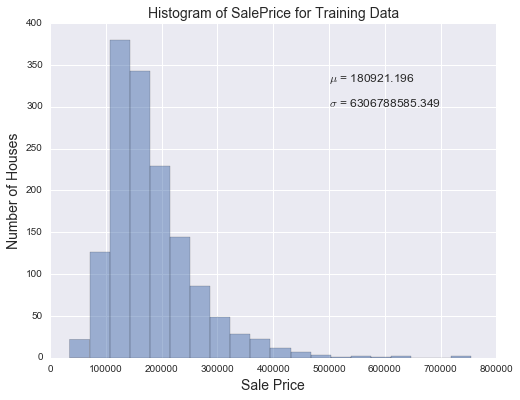

In [2]:
plt.hist(train_y.as_matrix(), bins = 20, alpha=0.5)
plt.grid(True)
#plt.title("SalePrice, $\mu$ = %0.3f, $\sigma$ = %0.3f" %(train_y.as_matrix().mean(), train_y.as_matrix().var()))
plt.title("Histogram of SalePrice for Training Data", size = 14)
plt.xlabel('Sale Price', size = 14)
plt.ylabel('Number of Houses', size = 14)
plt.text(500000, 330, "$\mu$ = %0.3f" %train_y.as_matrix().mean(), size = 12)
plt.text(500000, 300, "$\sigma$ = %0.3f" %train_y.as_matrix().var(), size = 12)
#plt.text(600000, 650, "$\mu$ = %0.3f, $\sigma$ = %0.3f" %(train_y.as_matrix().mean(), train_y.as_matrix().var()))
plt.show()

From the above hisogram we can see there is a very long tail. Most houses' prices are between 100000 to 400000. Directly analysis the sale price would make the variance very large. 

I analyze the skewness of the target values so we can find how asymmetry the target values would be.

In [3]:
train_y.skew()

SalePrice    1.882876
dtype: float64

So the skewness of target varialbe is very large. I tried another kind of expressions, which transforms the sale price by taking $log(1+SalePrice)$, to make the data more normal.
I draw another histogram of log sale price below:

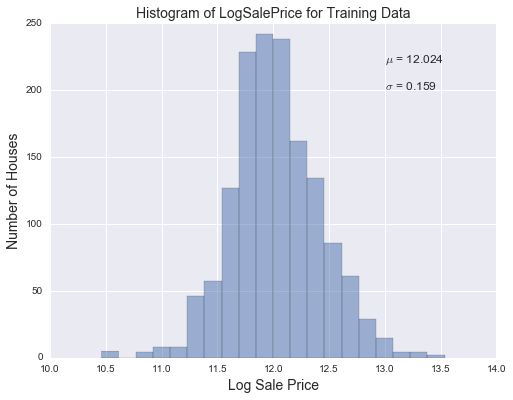

In [4]:
logprice = np.log1p(train_y.as_matrix())
plt.hist(logprice, bins = 20, alpha=0.5)
plt.grid(True)
plt.title("Histogram of LogSalePrice for Training Data", size = 14)
plt.xlabel('Log Sale Price', size = 14)
plt.ylabel('Number of Houses', size = 14)
plt.text(13, 220, "$\mu$ = %0.3f" %logprice.mean(), size = 12)
plt.text(13, 200, "$\sigma$ = %0.3f" %logprice.var(), size = 12)
#plt.text(600000, 650, "$\mu$ = %0.3f, $\sigma$ = %0.3f" %(train_y.as_matrix().mean(), train_y.as_matrix().var()))

plt.show()

### Visualize the distribution of house price in whole dataset

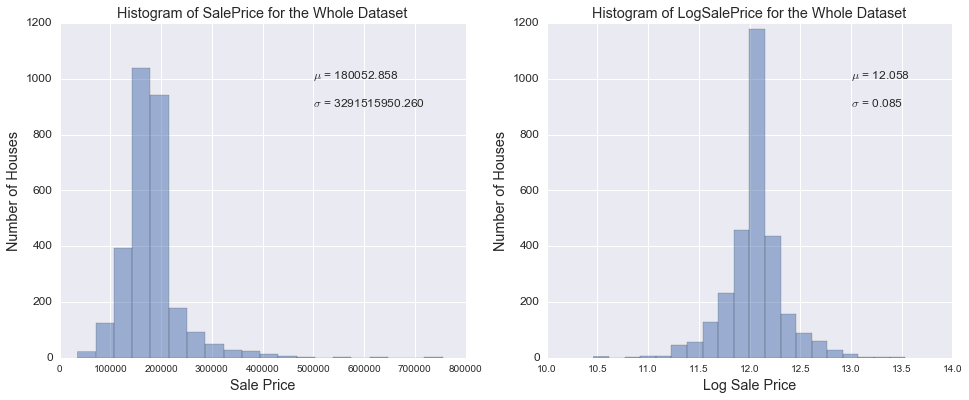

In [5]:
alldata_X = pd.concat((train_X, test_X), ignore_index = True)
## Transform target variable in testing data to integer
test_y = test_y.round(0).astype(int)
alldata_y = pd.concat((train_y, test_y), ignore_index = True)

plt.rcParams['figure.figsize'] = (16.0, 6.0)
plt.rcParams['xtick.labelsize'] = 'medium'
plt.rcParams['ytick.labelsize'] = 'large'
plt.rcParams['axes.titlesize'] = 'x-large'
plt.rcParams['axes.labelsize'] = 'x-large'

fig, axs = plt.subplots(1,2)
axs[0].hist(alldata_y.as_matrix(), bins = 20, alpha=0.5)
axs[0].grid(True)
axs[0].set_xlabel('Sale Price')
axs[0].set_ylabel('Number of Houses')
axs[0].text(500000, 1000, "$\mu$ = %0.3f" %alldata_y.as_matrix().mean(), size = 12)
axs[0].text(500000, 900, "$\sigma$ = %0.3f" %alldata_y.as_matrix().var(), size = 12)
axs[0].set_title("Histogram of SalePrice for the Whole Dataset")


logallprice = np.log1p(alldata_y.as_matrix())
axs[1].hist(logallprice, bins = 20, alpha=0.5)
axs[1].grid(True)
axs[1].set_title("Histogram of LogSalePrice for the Whole Dataset")
axs[1].set_xlabel('Log Sale Price')
axs[1].set_ylabel('Number of Houses')
axs[1].text(13, 1000, "$\mu$ = %0.3f" %logallprice.mean(), size = 12)
axs[1].text(13, 900, "$\sigma$ = %0.3f" %logallprice.var(), size = 12)

plt.show()

In [6]:
from sklearn import preprocessing
# trainy = preprocessing.scale(np.log1p(train_y))
# testy = preprocessing.scale(np.log1p(test_y))
trainy = np.log1p(train_y)
testy = np.log1p(test_y)

Now we have normalized the target values. Before further preprocessing the features, I want to remove some very irrelevant features based on last phase's data exploration. For example, for Utilities, the statistics look like:

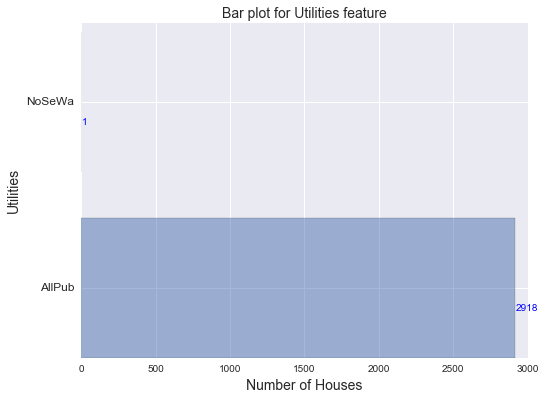

In [7]:
plt.rcParams['figure.figsize'] = (8, 6)

utilities_counts = alldata_X['Utilities'].value_counts()
#utilities_counts.sort_index(inplace = True)
index_ = utilities_counts.keys()
value_ = utilities_counts.get_values()

ind = np.arange(len(index_))
width = 0.75

fig, ax = plt.subplots()  
ax.barh(ind, value_, width, alpha=0.5)
ax.grid(True)
#ax.set_yticks(ind+width/2)
#ax.set_yticklabels(index_, minor=False)
plt.yticks(ind+width/2, index_)
plt.ylabel("Utilities", size = 14)
plt.xlabel("Number of Houses", size = 14)
plt.title("Bar plot for Utilities feature", size = 14)

for i, v in enumerate(value_):
    ax.text(v + 3, i+0.25 , str(v), color='blue')

plt.show()

In [8]:
alldata_X.drop('Street', axis=1, inplace = True) # only twelve is different
alldata_X.drop('Utilities', axis=1, inplace = True) # only one is different
alldata_X.drop('RoofMatl', axis=1, inplace = True)

Now I will preprocess the numerical fetures. I first log transform the features with high skewness (set threshold as 0.75). Then I scale the numerical features. Some numerical features are not suitable for z-scoring, so I will implement different scoring methods. Because the features in my dataset is very complicated. Some features are numerical but they should not be treated as numerical feature, like MSSubClass, each numerical value represents one class type. So I have to manually find the numerical features, instead of directly getting from data type in Pandas.

List all column names:

In [9]:
all_index = alldata_X.columns.values
all_index

array(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'LotShape',
       'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood',
       'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea',
       'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPo

In [10]:
num_index = ['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold']
cat_index = ['MSSubClass', 'MSZoning', 'LotShape', 'LandContour', 
            'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
             'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle',
             'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 
             'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
            'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
            'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
             'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition']

### Numerical features scaling
For most of numerical features, I will simply implement z-scoring to scale into 0 mean and 1 variance. But some numerical features are not suitable for z-scoring. For example, For the __YrSold__, which means _selling year_, which should not be scaled into 0 mean and 1 variance. I think the better method would be scaling values of year to a range. So for __time__ featues (including _month_ or _year_), I will implement _MinmaxScaler_ instead of _z-scoring_. Also, some numerical features like __OverallQual__ or __OverallCond__, represents the quality for this house. The value for this feature is a quality score. So again, I think for these kind of score features, _MinmaxScaler_ would be better than _z-scoring_.

Below, I scale all the numerical features into a range or 0 mean and 1 variance. (Based on the feature type)

In [11]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import scale

num_index_score = ['OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'MoSold', 'YrSold']
num_index_others = list(set(num_index) - set(num_index_score))

alldata_X[num_index_score] = alldata_X[num_index_score].apply(lambda x : MinMaxScaler().fit_transform(x))
alldata_X[num_index_others] = alldata_X[num_index_others].apply(lambda x : scale(x))

/Applications/anaconda/lib/python3.5/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Applications/anaconda/lib/python3.5/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Applications/anaconda/lib/python3.5/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if yo

### Categorical features encoding
I have scale all the numerical features, then I will encode categorical features. Here I use __One-Hot-Encoding__ method to encode all categorical features.

In [12]:
alldata_X['MSSubClass'] = alldata_X['MSSubClass'].astype(object)
alldata_X = pd.get_dummies(alldata_X)

Now I have finished all feature enginering works. Let's take a look at how does data look like now.

In [13]:
alldata_X.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SaleType_New,SaleType_NoSale,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,-0.192299,-0.217879,0.666667,0.500,0.949275,0.883333,0.532144,0.581145,-0.292374,-0.933391,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.511345,-0.072044,0.555556,0.875,0.753623,0.433333,-0.564669,1.178255,-0.292374,-0.628628,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,-0.051570,0.137197,0.666667,0.500,0.934783,0.866667,0.341880,0.098189,-0.292374,-0.287475,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,-0.426847,-0.078385,0.666667,0.500,0.311594,0.333333,-0.564669,-0.494529,-0.292374,-0.046394,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.698984,0.518903,0.777778,0.500,0.927536,0.833333,1.393925,0.469187,-0.292374,-0.160112,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [14]:
train_X = alldata_X[: train_X.shape[0]]
test_X = alldata_X[train_X.shape[0]:]
trainX = train_X.as_matrix()
testX = test_X.as_matrix()

### Performance measure metric: __RMSE__
I will use __Root Mean Squared Error__ as the performance measure metric in my project.

### Baseline: RMSE of predicting the mean of the target.

Because the target values in testing data are not the groundtruth, it's just a benchmark submission from a linear regression on year and month of sale, lot square footage, and number of bedrooms. So for my project, the best choice of evaluation should be based on cross-validation over training set. Calculating RMSE over testing dataset will introduce a lot of bias for my model real performance, because I have no real groundtruth for testing data. So I will calculate two baselines, first is based on the full dataset (training + testing) and second is just based on training dataset (which have the true groundtruth).

#### Baseline over all dataset

In [15]:
from sklearn.metrics import mean_squared_error
ytrue = np.append(trainy, testy)
meany = np.mean(ytrue)
ypredict = np.repeat(meany, len(ytrue))

baseRMSE = np.sqrt(mean_squared_error(ytrue, ypredict))
baseRMSE

0.29147816770677093

#### Baseline over training dataset

In [16]:
from sklearn.metrics import mean_squared_error
#ytrue = np.append(trainy, testy)
meany = np.mean(trainy)
ypredict = np.repeat(meany, len(trainy))

baseRMSE = np.sqrt(mean_squared_error(trainy, ypredict))
baseRMSE

0.39931245219387496

In [17]:
from sklearn.model_selection import cross_val_score
def rmse_cv(model):
    rmse = np.sqrt(-cross_val_score(model, trainX, trainy, scoring = "neg_mean_squared_error", cv = 10))
    return rmse

#### 1. Lasso regression model
* For the lasso regression model, the main parameter is the weight of regularization _alpha_.
* I set the value of _alpha_ as [0.0005, 0.001,0.01, 0.05, 0.1, 0.3, 0.5, 1, 5, 20, 50]

In [18]:
from sklearn.linear_model import Lasso

alphas = [1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2, 0.1, 0.3, 0.5]
#model_lasso = LassoCV()
cv_lasso = [rmse_cv(Lasso(alpha = alpha, max_iter = 500000)).mean() for alpha in alphas]

In [19]:
cv_lasso

[0.14194947479204834,
 0.13503562534344735,
 0.13598294133110242,
 0.16020335991421256,
 0.17759810284410704,
 0.22410063074982176,
 0.2583190633978214,
 0.39863740799010461,
 0.39863740799010461]

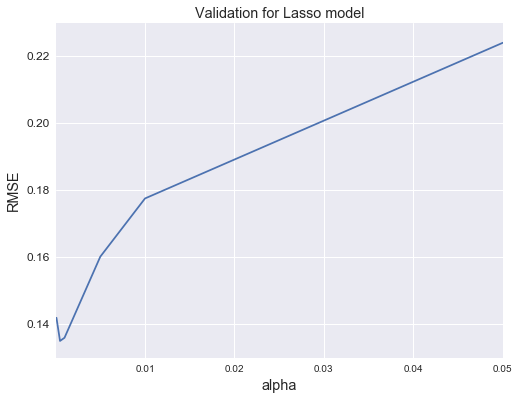

In [20]:
pd.Series(cv_lasso[:6], index = alphas[:6]).plot(title = "Validation for Lasso model", grid = True)
plt.xlabel('alpha')
plt.ylabel("RMSE")

In [21]:
best_alpha_for_lasso = alphas[np.argmin(np.array(cv_lasso))]
best_alpha_for_lasso

0.0005

Then we first train Lasso model with best parameter we choose from 10 cross-validation, and then test over the testing dataset.

In [22]:
model_lasso = Lasso(alpha = best_alpha_for_lasso)
model_lasso.fit(trainX, trainy)
rmse_lasso_test = np.sqrt(mean_squared_error(testy, model_lasso.predict(testX)))
rmse_lasso_test

0.43856846239088049

### Feature selection for Lasso model
I want to analyze the feature importance in Lasso model with the best parameter (alpha = 0.0005). So I will show the top 10 positive features and top 10 negative features.

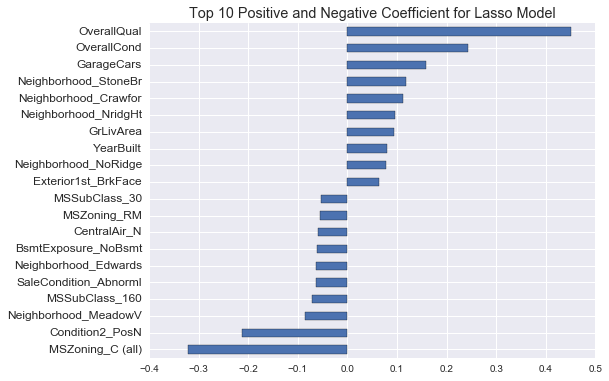

In [23]:
coef = pd.Series(model_lasso.coef_, index = train_X.columns).sort_values()
importance_coef_lasso = pd.concat([coef.head(10), coef.tail(10)])
importance_coef_lasso.plot(kind = 'barh', grid = True)
plt.title("Top 10 Positive and Negative Coefficient for Lasso Model")

So obviously the top 10 positive features are:

In [24]:
coef.tail(10).axes

[Index(['Exterior1st_BrkFace', 'Neighborhood_NoRidge', 'YearBuilt', 'GrLivArea',
        'Neighborhood_NridgHt', 'Neighborhood_Crawfor', 'Neighborhood_StoneBr',
        'GarageCars', 'OverallCond', 'OverallQual'],
       dtype='object')]

In [25]:
coef.tail(10).sort_values(ascending = False)

OverallQual             0.451594
OverallCond             0.242682
GarageCars              0.159261
Neighborhood_StoneBr    0.118166
Neighborhood_Crawfor    0.111492
Neighborhood_NridgHt    0.096090
GrLivArea               0.093552
YearBuilt               0.079863
Neighborhood_NoRidge    0.076711
Exterior1st_BrkFace     0.063258
dtype: float64

Let's visualize the our Lasso model's performance.

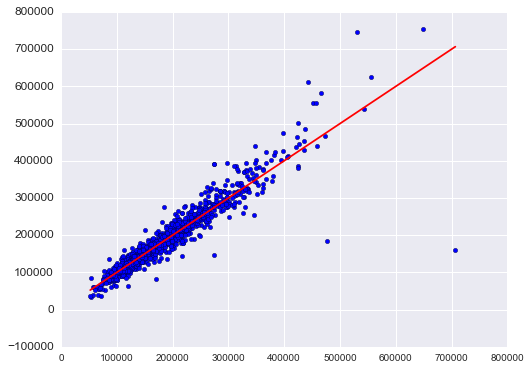

In [26]:
lasso_pred = np.expm1(model_lasso.predict(trainX))
plt.scatter(lasso_pred, np.expm1(trainy))
plt.plot([min(lasso_pred),max(lasso_pred)], [min(lasso_pred),max(lasso_pred)], c="red")

#### 2. RBF kernel Support Vector Regression model
* For the support vector regression, the parameters are:
* C: penalty parameter for error term, we set [0.01, 0.1, 0.5, 1, 5, 20]
* epsilon: epsilon for epsilon-SVR and specifies the epsilon-tube within which no penalty is associated. We set [0.005, 0.01, 0.1, 0.5, 1, 5]
* Kernel: kernel function, we set ['rbf', 'linear', 'sigmoid']

In [27]:
from sklearn.svm import SVR
C = [0.1, 0.5, 1, 5]
epsilon = [0.01, 0.1, 0.5, 1]
# We will not validate kernel function, because it consumes a lot of time for corss-validation
#kernel = ['rbf', 'linear', 'sigmoid']
#cv_svr = np.empty([len(C), len(epsilon), len(kernel)])
cv_svr = np.empty([len(C), len(epsilon)])
for i in range(len(C)):
    for j in range(len(epsilon)):
        #for k in range(len(kernel)):
            #cv_svr[i][j][k] = rmse_cv(SVR(C = C[i], epsilon = epsilon[j], kernel = kernel[k])).mean()
        cv_svr[i][j] = rmse_cv(SVR(C = C[i], epsilon = epsilon[j])).mean()
            

So for each parameter setting, the mean RMSE for each fold is:

In [28]:
cv_svr

array([[ 0.14742415,  0.15066238,  0.23213525,  0.33547819],
       [ 0.1289185 ,  0.13304933,  0.21640788,  0.34206156],
       [ 0.12367765,  0.12784019,  0.22312797,  0.34221506],
       [ 0.12092181,  0.12604594,  0.21973062,  0.34221506]])

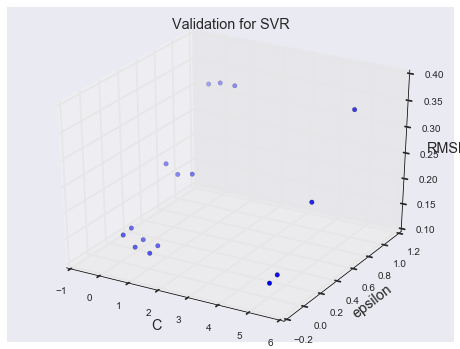

In [29]:
from mpl_toolkits.mplot3d import Axes3D

threedee = plt.figure().gca(projection='3d')

c1d = np.repeat(C, len(epsilon))
e1d = np.array(epsilon* len(C))
cv_svr1d = np.array(cv_svr).flatten()

threedee.scatter(c1d, e1d, cv_svr1d)
threedee.set_xlabel('C')
threedee.set_ylabel('epsilon')
threedee.set_zlabel('RMSE')
threedee.set_title('Validation for SVR')

plt.show()

Now we choose the best C and epsilon for SVR regression model.

In [30]:
minindex = np.unravel_index(np.argmin(cv_svr), cv_svr.shape)
best_c_for_svr = C[minindex[0]]
best_e_for_svr = epsilon[minindex[1]]
best_c_for_svr, best_e_for_svr

(5, 0.01)

Then we first train SVR model with best parameter we choose from 10 cross-validation, and then test over the testing dataset.

In [31]:
model_svr = SVR(C = best_c_for_svr, epsilon = best_e_for_svr)
model_svr.fit(trainX, trainy)
rmse_svr_test = np.sqrt(mean_squared_error(testy, model_svr.predict(testX)))
rmse_svr_test

0.37651340631256569

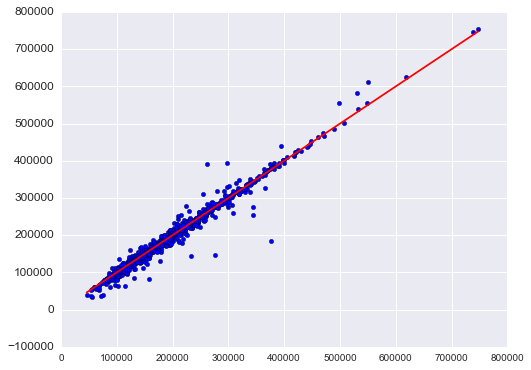

In [32]:
svr_pred = np.expm1(model_svr.predict(trainX))
plt.scatter(svr_pred, np.expm1(trainy))
plt.plot([min(svr_pred),max(svr_pred)], [min(svr_pred),max(svr_pred)], c="red")